In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import warnings
import os
from math import sqrt
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error ,r2_score

In [ ]:
# Specify the directory containing the CSV files
directory = '/content/drive/MyDrive/DATA_298B/DATA/ChargingTransactionData/TransitBus'

# Initialize an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)

        # Read each CSV file and concatenate it to the combined_data DataFrame
        df = pd.read_csv(file_path)
        combined_data = pd.concat([combined_data, df], ignore_index=True)

# Save the combined data to a new CSV file
combined_data.to_csv('/content/drive/MyDrive/DATA_298B/DATA/ChargingTransactionData/TransitBus/combined_data.csv', index=False)

# Print a summary of the combined data
print(f'Combined data shape: {combined_data.shape}')


Combined data shape: (106731, 18)


In [ ]:
combined_data.columns

Index(['Vehicle ID', 'Charger ID', 'Local Connect Time',
       'Local Disconnect Time', 'Local Charge Start Time',
       'Local Charge End Time', 'Average Power', 'Max Power',
       'Total Energy Delivered', 'Starting SOC', 'Ending SOC', 'Date',
       'Number of Charging Sessions', 'Connection Time', 'Charging Time',
       'SOC Charged', 'Starting SOC ', 'Local Charge E/Time'],
      dtype='object')

In [ ]:
charging_data = pd.read_csv('/content/drive/MyDrive/DATA_298B/DATA/ChargingTransactionData/TransitBus/charging.ev032.fleet05.2017.proterra.8.79.500.ca.ptr.ptr.tra.vir.csv')
# Function to replace spaces with underscores in column names
def clean_column_names(df):
    df.columns = df.columns.str.replace(' ', '_')
clean_column_names(charging_data)
charging_data.drop(columns=['Local_Connect_Time','Local_Disconnect_Time'], inplace=True)
charging_data.rename(columns={'Local_Charge_E/Time': 'Local_Charge_End_Time'}, inplace=True)
charging_data['Local_Charge_Start_Time'] = pd.to_datetime(charging_data['Local_Charge_Start_Time'])
charging_data['Local_Charge_End_Time'] = pd.to_datetime(charging_data['Local_Charge_End_Time'])


In [ ]:
charging_data.columns

Index(['Vehicle_ID', 'Charger_ID', 'Local_Charge_Start_Time',
       'Local_Charge_End_Time', 'Average_Power', 'Max_Power',
       'Total_Energy_Delivered', 'Starting_SOC', 'Ending_SOC'],
      dtype='object')

In [ ]:
charging_data.isnull().sum()

Vehicle_ID                 0
Charger_ID                 0
Local_Charge_Start_Time    0
Local_Charge_End_Time      0
Average_Power              0
Max_Power                  0
Total_Energy_Delivered     0
Starting_SOC               2
Ending_SOC                 0
dtype: int64

In [ ]:
# Drop rows with null values from the DataFrame
charging_data.dropna(inplace=True)


In [ ]:
# Calculate SOC change (delta SOC), Charging Duration, Average Power
charging_data['Delta_SOC'] = charging_data['Ending_SOC'] - charging_data['Starting_SOC']
charging_data['Charging_Duration'] = (charging_data['Local_Charge_End_Time'] - charging_data['Local_Charge_Start_Time']).dt.total_seconds() / 3600  # in hours

# Select relevant features for prediction
features = ['Charging_Duration', 'Average_Power' , 'Delta_SOC']

charging_data['Range'] = (charging_data['Delta_SOC'] / 100) * 492 / 2.05


# Use delta SOC as the target variable (what you want to predict)
target = 'Range'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(charging_data[features], charging_data[target], test_size=0.2, random_state=42)

# Create individual models
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_gb = GradientBoostingRegressor(random_state=42)
model_lr = LinearRegression()

# Create a BaggingRegressor ensemble
bagged_model = BaggingRegressor(base_estimator=model_rf, n_estimators=10, random_state=42)

# Create a StackingRegressor with Random Forest, Gradient Boosting, and Linear Regression as base models
stacked_model = StackingRegressor(estimators=[
    ('rf', model_rf),
    ('gb', model_gb),
    ('lr', model_lr)
], final_estimator=LinearRegression())

# Create a VotingRegressor with all models
voting_model = VotingRegressor(estimators=[
    ('rf', model_rf),
    ('gb', model_gb),
    ('lr', model_lr),
    ('bagged', bagged_model),
    ('stacked', stacked_model)
])

# Train individual models
model_rf.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
model_lr.fit(X_train, y_train)

# Train bagged model
bagged_model.fit(X_train, y_train)

# Train stacked model
stacked_model.fit(X_train, y_train)

# Train voting model
voting_model.fit(X_train, y_train)

# Make predictions for each model
y_pred_rf = model_rf.predict(X_test)
y_pred_gb = model_gb.predict(X_test)
y_pred_lr = model_lr.predict(X_test)
y_pred_bagged = bagged_model.predict(X_test)
y_pred_stacked = stacked_model.predict(X_test)
y_pred_voting = voting_model.predict(X_test)

# Assign weights to each model's predictions
weights = {
    'rf': 0.2,
    'gb': 0.2,
    'lr': 0.1,
    'bagged': 0.2,
    'stacked': 0.2
}

# Calculate the weighted fusion of predictions
weighted_fusion = (
    weights['rf'] * y_pred_rf +
    weights['gb'] * y_pred_gb +
    weights['lr'] * y_pred_lr +
    weights['bagged'] * y_pred_bagged +
    weights['stacked'] * y_pred_stacked
)

# Make predictions using the weighted fusion model
y_pred_fusion = weighted_fusion

# Evaluate the weighted fusion model
mse_fusion = mean_squared_error(y_test, weighted_fusion)
mae_fusion = mean_absolute_error(y_test, weighted_fusion)
rmse_fusion=sqrt(mean_squared_error(y_test, weighted_fusion))
r2_fusion = r2_score(y_test, y_pred_fusion)
print(f"Mean Squared Error (Weighted Fusion): {mse_fusion}")
print(f"Mean Absolute Error (Weighted Fusion): {mae_fusion}")
print(f"Mean Squared Error (Weighted Fusion): {rmse_fusion}")
print(f"R-squared (Weighted Fusion): {r2_fusion}")

Mean Squared Error (Weighted Fusion): 88.11144192923555
Mean Absolute Error (Weighted Fusion): 9.060315159973557
Mean Squared Error (Weighted Fusion): 9.386769515080017
R-squared (Weighted Fusion): 0.8554705919046025


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt


X = charging_data[['Average_Power', 'Max_Power', 'Starting_SOC', 'Ending_SOC', 'Charging_Duration']]
y = charging_data['Total_Energy_Delivered']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models (Random Forest, Gradient Boosting, MLP)
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=10000, random_state=42))
]

# Train base models and make predictions
base_model_predictions = {}
for name, model in base_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    base_model_predictions[name] = y_pred

# Weighted Fusion (you can adjust weights based on validation performance)
weights = {'rf': 0.4, 'gb': 0.4, 'mlp': 0.2}
weighted_predictions = sum(weights[model] * prediction for model, prediction in base_model_predictions.items())


mse_fusion = mean_squared_error(y_test, weighted_predictions)
mae_fusion = mean_absolute_error(y_test, weighted_predictions)
rmse_fusion=sqrt(mean_squared_error(y_test, weighted_predictions))
r2_fusion = r2_score(y_test, weighted_predictions)

print(f"Mean Squared Error (Weighted Fusion): {mse_fusion}")
print(f"Mean Absolute Error (Weighted Fusion): {mae_fusion}")
print(f"Mean Squared Error (Weighted Fusion): {rmse_fusion}")
print(f"R-squared (Weighted Fusion): {r2_fusion}")

Mean Squared Error (Weighted Fusion): 4.3666317324633575
Mean Absolute Error (Weighted Fusion): 0.8690907436258539
Mean Squared Error (Weighted Fusion): 2.0896487103011734
R-squared (Weighted Fusion): 0.9317097641577153


In [ ]:
# Make predictions using the stacked model for forecasting EV energy demand
data =  charging_data[['Local_Charge_Start_Time','Average_Power', 'Max_Power', 'Starting_SOC', 'Ending_SOC', 'Charging_Duration','Total_Energy_Delivered']]
# Set the 'Timestamp' column as the index
data.set_index('Local_Charge_Start_Time', inplace=True)

# Resample the data for daily, weekly, and monthly forecasts
daily_forecast = data.resample('D').mean()
weekly_forecast = data.resample('W').mean()
monthly_forecast = data.resample('M').mean()

x_d=daily_forecast.drop(columns=['Total_Energy_Delivered'])
x_w=weekly_forecast.drop(columns=['Total_Energy_Delivered'])
x_m=monthly_forecast.drop(columns=['Total_Energy_Delivered'])

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
daily_forecast_imputed = imputer.fit_transform(x_d)
weekly_forecast_imputed = imputer.transform(x_w)
monthly_forecast_imputed = imputer.transform(x_m)

hgb_model = HistGradientBoostingRegressor(random_state=42)
hgb_model.fit(X_train, y_train)

# Predict energy demand for each resampled dataset using HistGradientBoostingRegressor
daily_predictions = hgb_model.predict(daily_forecast_imputed)
weekly_predictions = hgb_model.predict(weekly_forecast_imputed)
monthly_predictions = hgb_model.predict(monthly_forecast_imputed)

In [ ]:
monthly_forecast

,Average_Power,Max_Power,Starting_SOC,Ending_SOC,Charging_Duration,Total_Energy_Delivered
Local_Charge_Start_Time,,,,,,
2018-01-31,230.756000,298.048872,51.793233,91.488722,0.136341,29.021594
2018-02-28,234.649350,300.472000,50.879167,92.004167,0.169167,29.969942
2018-03-31,186.202639,237.322532,56.639241,91.857595,0.153270,25.125943
2018-04-30,215.297506,279.485517,59.387931,94.025862,0.143487,24.704121
2018-05-31,245.237020,308.616939,63.336735,96.576531,0.120238,23.594765
2018-06-30,252.317563,331.284423,58.002404,95.149038,0.136538,27.080236
2018-07-31,259.351796,337.040905,59.631222,97.217195,0.124434,27.506611
2018-08-31,257.955053,335.258133,57.500000,96.573333,0.122444,28.732040


In [ ]:
weekly_forecast

,Average_Power,Max_Power,Starting_SOC,Ending_SOC,Charging_Duration,Total_Energy_Delivered
Local_Charge_Start_Time,,,,,,
2018-01-07,249.474250,320.931000,59.637500,95.037500,0.126250,25.413500
2018-01-14,198.526074,264.076296,50.092593,91.777778,0.154938,30.404963
2018-01-21,235.863538,294.667692,49.884615,88.923077,0.126923,28.856462
2018-01-28,237.893718,306.240513,50.012821,90.512821,0.129915,30.050205
2018-02-04,232.244000,298.310769,42.769231,87.173077,0.145513,31.902423
2018-02-11,234.165132,300.935263,53.342105,92.855263,0.135088,28.905816
2018-02-18,270.915250,352.178333,47.375000,90.625000,0.123611,32.340250
2018-02-25,252.906229,324.002286,52.442857,93.800000,0.179048,30.293543
2018-03-04,162.424304,209.955217,48.663043,89.836957,0.244928,29.149761


In [ ]:
daily_forecast

,Average_Power,Max_Power,Starting_SOC,Ending_SOC,Charging_Duration,Total_Energy_Delivered
Local_Charge_Start_Time,,,,,,
2018-01-02,-0.730500,-0.700000,60.750000,60.500000,0.050000,0.012500
2018-01-03,10.968000,20.360000,60.750000,74.000000,0.250000,6.558000
2018-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,285.547308,356.476923,57.769231,96.346154,0.120513,28.323385
2018-01-06,263.824364,350.298182,60.500000,99.090909,0.124242,27.843273
...,...,...,...,...,...,...
2018-08-09,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-10,247.878692,335.543077,56.307692,93.884615,0.112821,28.016538
2018-08-11,250.959364,321.694545,51.681818,96.181818,0.142424,32.949727


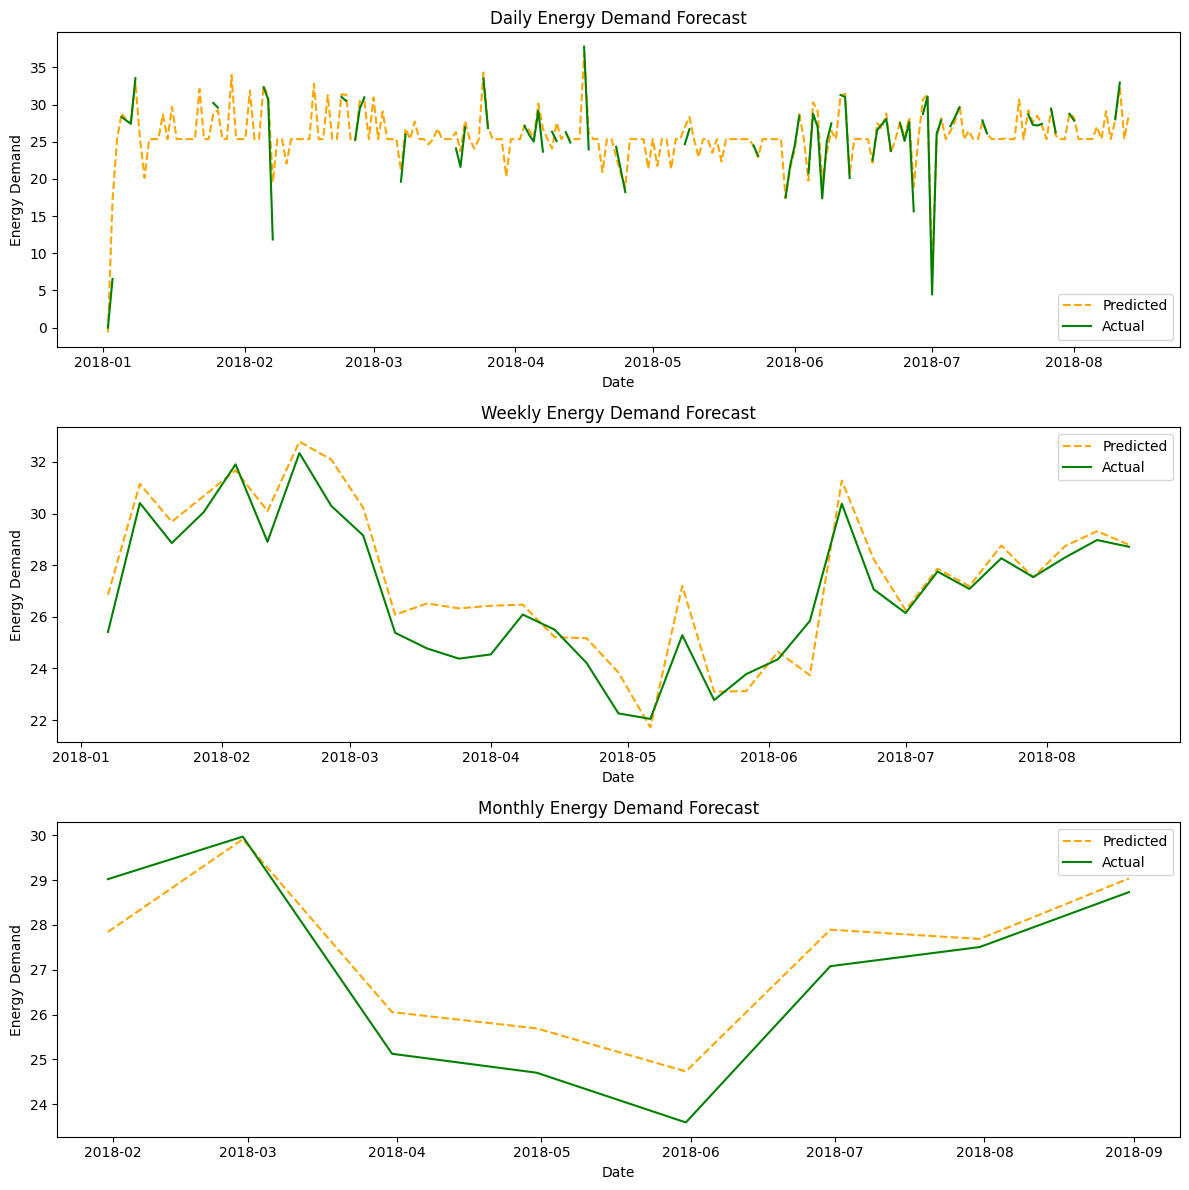

In [ ]:
# Plot the predictions along with the actual data
plt.figure(figsize=(12, 12))

# Daily Forecast
plt.subplot(311)
plt.plot(daily_forecast.index, daily_predictions, label='Predicted', color='orange', linestyle='--')
plt.plot(daily_forecast.index, daily_forecast['Total_Energy_Delivered'], label='Actual', color='green')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Daily Energy Demand Forecast')
plt.legend()

# Weekly Forecast
plt.subplot(312)
plt.plot(weekly_forecast.index, weekly_predictions, label='Predicted', color='orange', linestyle='--')
plt.plot(weekly_forecast.index, weekly_forecast['Total_Energy_Delivered'], label='Actual', color='green')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Weekly Energy Demand Forecast')
plt.legend()

# Monthly Forecast
plt.subplot(313)
plt.plot(monthly_forecast.index, monthly_predictions, label='Predicted', color='orange', linestyle='--')
plt.plot(monthly_forecast.index, monthly_forecast['Total_Energy_Delivered'], label='Actual', color='green')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Monthly Energy Demand Forecast')
plt.legend()

plt.tight_layout()
plt.show()
